## Vector DB LLM 평가 루프 통합

분석 및 통합 전략
- 기본 프레임워크 유지: 라우터(Router) 기반 분기 처리(sequential, parallel, neo4j_only, vector_db_only)

- VectorDB 검색 로직 교체: mcp_langgraph_hw.ipynb의 단순한 vector_db 노드를 고도화된 검색 및 평가 루프(Subgraph)로 통째로 교체

통합 지점 설정:

- 진입점: 라우터가 vector_db_only, parallel, sequential 흐름으로 결정하면, 기존의 단순 vector_db 노드 대신 새로 통합된 **gpt_query_rewriter_node (쿼리 재작성 노드)**로 진입합니다. neo4j_only 흐름은 이 루프를 완전히 건너뛰고 바로 최종 답변 노드로 갑니다.

- 탈출점: 새로운 검색/평가 루프는 자체적으로 최적의 문서를 찾거나, 최대 재시도 횟수에 도달하면 종료됩니다. 루프가 종료되면, 검색된 최종 문서(vector_documents)를 가지고 기존의 **merge_and_respond (최종 답변 생성 및 슬랙 전송 노드)**로 돌아와서 전체 워크플로우를 마무리합니다.

- State 통합: 두 노트북의 State를 합쳐 모든 노드에서 필요한 정보를 담을 수 있는 확장된 ChatbotState를 정의합니다. (loop_cnt, llm_evaluation 등 추가)

In [1]:
# ==============================================================================
# 셀 1: 라이브러리 임포트 및 기본 설정
# ==============================================================================
from typing import Annotated, List, TypedDict, Dict
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
import os
import json
import re
import asyncio
import pandas as pd

# LangChain 관련 임포트
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langchain_mcp_adapters.client import MultiServerMCPClient

# 환경 변수 로드
load_dotenv()

# OpenAI 모델 설정
model = ChatOpenAI(temperature=0.2, model_name="gpt-4o")

In [2]:
# ==============================================================================
# 셀 2: 통합 State 정의 및 메모리 설정
# ==============================================================================
class ChatbotState(TypedDict):
    # --- 기존 mcp_langgraph_hw.ipynb의 State ---
    question: Annotated[str, "사용자 원본 질문 (mcp_langgraph_hw)"]
    flow_type: Annotated[str, "데이터베이스 조회 흐름 (mcp_langgraph_hw)"]
    patient_info: Annotated[str, "순차 처리를 위한 환자 정보 (mcp_langgraph_hw)"]
    decision_slack: Annotated[str, "슬랙 전송 여부 결정 (mcp_langgraph_hw)"]
    tools_query: Annotated[List[str], "각 DB에 전달할 쿼리 리스트 (mcp_langgraph_hw)"]
    neo4j_documents: Annotated[List, "Neo4j 검색 결과 (mcp_langgraph_hw)"]
    final_answer: Annotated[str, "최종 답변 (mcp_langgraph_hw)"]
    slack_response: Annotated[str, "슬랙 전송 결과 (mcp_langgraph_hw)"]
    messages: List[BaseMessage]

    # --- VectorDB_Retrieval.ipynb에서 추가된 State ---
    current_query: Annotated[str, "현재 VectorDB 검색에 사용되는 쿼리 (VectorDB_Retrieval)"]
    query_variants: Annotated[List[str], "생성된 쿼리 변형 목록 (VectorDB_Retrieval)"]
    vector_documents: Annotated[str, "VectorDB 검색 결과 텍스트 (VectorDB_Retrieval)"]
    llm_evaluation: Annotated[Dict, "LLM 평가 결과 (VectorDB_Retrieval)"]
    loop_cnt: Annotated[int, "재시도 루프 카운트 (VectorDB_Retrieval)"]

# LangGraph 메모리 설정
memory = MemorySaver()

In [4]:
# ==============================================================================
# 셀 3: MCP 클라이언트 및 도구 설정
# ==============================================================================
mcp_client = MultiServerMCPClient(
    {
        "neo4j_retriever": { 
            "command": "/home/hyewon/boaz/bin/python",
            "args": ["/home/hyewon/boaz/mcp/mcp_neo4j_server.py"],
            "transport": "stdio",
        },
        "VectorDB_retriever": {
            "command": "/home/hyewon/boaz/bin/python",
            "args": ["/home/hyewon/boaz/mcp/mcp_vectordb_server.py"],
            "transport": "stdio",
        },
        "slack": {
            "command": "npx",
            "args": ["-y", "@modelcontextprotocol/server-slack"],
            "transport": "stdio", 
            "env": {
                "SLACK_BOT_TOKEN": os.getenv("SLACK_BOT_TOKEN"),
                "SLACK_TEAM_ID": os.getenv("SLACK_TEAM_ID"),
                # 선택사항: 특정 채널만 접근하려는 경우
                # "SLACK_CHANNEL": os.getenv("SLACK_CHANNEL"),
            }
        }
    }
)

# 비동기적으로 도구 로드 및 딕셔너리 생성
async def setup_tools():
    global tools_dict
    mcp_tools = await mcp_client.get_tools()
    tools_dict = {tool.name: tool for tool in mcp_tools}
    print("MCP 도구 설정 완료:", list(tools_dict.keys()))
    
# 이벤트 루프에서 도구 설정 실행 (Jupyter 환경)
if 'tools_dict' not in globals():
    await setup_tools()

MCP 도구 설정 완료: ['neo4j_retriever', 'VectorDB_retriever', 'slack_list_channels', 'slack_post_message', 'slack_reply_to_thread', 'slack_add_reaction', 'slack_get_channel_history', 'slack_get_thread_replies', 'slack_get_users', 'slack_get_user_profile']


In [6]:
import os
import pandas as pd

# 1. 경로 확인
xls_path = "/mnt/c/Users/user/BOAZ_ADV/Hyewon/mcp/Pediatric_Terminology.xls"
if not os.path.exists(xls_path):
    raise FileNotFoundError(f"파일을 찾을 수 없습니다: {xls_path}")
print("✅ 파일이 존재합니다:", xls_path)

# 2. 엑셀 파일 읽기 (첫 번째 시트만 불러오기)
#    여러 시트를 모두 보고 싶으면 sheet_name=None 으로 변경하세요.
df = pd.read_excel(xls_path, sheet_name=0, engine="xlrd")

# 3. 상위 5개 행 출력
print("\n=== 첫 번째 시트 상위 5개 행 ===")
print(df.head())


✅ 파일이 존재합니다: /mnt/c/Users/user/BOAZ_ADV/Hyewon/mcp/Pediatric_Terminology.xls

=== 첫 번째 시트 상위 5개 행 ===
  NCIt Code of Subset Peds Subset Preferred Term NCIt Concept Code  \
0              C90259          NICHD Terminology           C100104   
1              C90259          NICHD Terminology           C101022   
2              C90259          NICHD Terminology           C101023   
3              C90259          NICHD Terminology           C101024   
4              C90259          NICHD Terminology           C101025   

                      NCIt PT         Peds Preferred Term  \
0             Sign or Symptom             Sign or Symptom   
1  Cerebral Arterial Aneurysm  Cerebral Arterial Aneurysm   
2    Cerebral Venous Aneurysm    Cerebral Venous Aneurysm   
3               Colon Atresia               Colon Atresia   
4            Duodenal Atresia            Duodenal Atresia   

                     Peds Synonym  \
0               Signs or Symptoms   
1                             NaN   

In [5]:
# ==============================================================================
# 셀 4: 쿼리 재작성기 및 LLM 평가기 설정
# ==============================================================================

# --- 동의어 사전 구축 ---
# ※ 중요: 아래 파일 경로는 실제 환경에 맞게 수정해야 합니다.
# ※ 또한, 이 코드를 실행하려면 'xlrd' 라이브러리가 필요합니다. (pip install xlrd)
XLS_PATH = "/mnt/c/Users/user/BOAZ_ADV/Hyewon/mcp/Pediatric_Terminology.xls" # <<<--- 실제 파일 경로로 변경

def build_term_dict_from_xls(xls_path: str):
    term_dict: Dict[str, List[str]] = {}
    try:
        sheets = pd.read_excel(xls_path, sheet_name=None, engine="xlrd")
        for df in sheets.values():
            df = df.rename(columns=lambda c: c.strip())
            if {"Peds Preferred Term", "Peds Synonym"} <= set(df.columns):
                for pref, syns in zip(df["Peds Preferred Term"], df["Peds Synonym"]):
                    if pd.isna(pref): continue
                    pref = str(pref).strip().lower()
                    syn_list = [s.strip().lower() for s in re.split(r"[|;,]", str(syns)) if s and s.strip()] if isinstance(syns, str) else []
                    term_dict.setdefault(pref, []).extend(syn_list + [pref])
        return {k: sorted(set(v)) for k, v in term_dict.items()}
    except FileNotFoundError:
        print(f"!!! 경고: 동의어 사전 파일({xls_path})을 찾을 수 없습니다. 동의어 확장이 비활성화됩니다.")
        return {}
    except ImportError:
        print("!!! 경고: 'xlrd' 라이브러리가 필요합니다. (pip install xlrd). 동의어 확장이 비활성화됩니다.")
        return {}

PEDIATRIC_TERMS = build_term_dict_from_xls(XLS_PATH)

# --- 쿼리 한글 -> 영어 번역 유틸 ---
async def ko2en(text: str, model_name: str = "gpt-4o-mini"):
    llm = ChatOpenAI(model_name=model_name, temperature=0.0)
    resp = await llm.ainvoke(f"Translate the following pediatric-anesthesia question to English (keep medical terms and abbreviations):\n{text}")
    return resp.content.strip()

# --- GPT 쿼리 재작성기 클래스 ---
class GPTQueryRewriter:
    def __init__(self, model_name: str = "gpt-4o-mini", temperature: float = 0.2):
        self.llm = ChatOpenAI(model_name=model_name, temperature=temperature, max_tokens=300)

    async def rewrite(self, question, mode="initial"):
        question_en = await ko2en(question) if not question.isascii() else question
        prompt = (
            "You are a pediatric-anesthesia search expert.\n"
            "Rewrite the following question into ONE concise English search query optimised for a vector database.\n"
            f"Synonym dictionary: {json.dumps(PEDIATRIC_TERMS, ensure_ascii=False)}\n"
            "Guidelines:\n"
            "① Preserve key medical terms/abbreviations.\n"
            "② Expand synonyms with OR (e.g., neonatal OR newborn).\n"
            "③ Remove stop-words and unnecessary fillers.\n"
            "Return ONLY the search query."
        )
        if mode == "improvement": prompt += "\n(Previous results were unsatisfactory. Try a different angle.)"
        prompt += f"\n\nUser question: {question_en}\n→"
        return (await self.llm.ainvoke(prompt)).content.strip()

# --- LLM 평가기 클래스 ---
class LLMEvaluator:
    def __init__(self, model_name="gpt-4o-mini", temperature=0.0):
        self.judge = ChatOpenAI(model_name=model_name, temperature=temperature, max_tokens=500)

    async def evaluate_search_results(self, query: str, docs: List[str]) -> Dict:
        if not docs: return self._default("no documents")
        previews = [d[:200].replace("\n", " ") + "…" for d in docs[:3]]
        prompt = f"""
            You are an independent evaluator for a PubMed-based RAG system.
            Task ◂ Evaluate how well the retrieved abstracts answer the user query.
            Metrics (0-1):
            1. relevance    – topical overlap between query and abstracts.
            2. faithfulness – factual alignment: does the evidence really support the answer?
            3. completeness – does the evidence cover all key aspects of the question?
            Return **one JSON**: {{\"relevance\": 0.0, \"faithfulness\": 0.0, \"completeness\": 0.0, \"overall\": 0.0, \"feedback\": \"\"}}
            overall = 0.4*relevance + 0.35*faithfulness + 0.25*completeness
            User query: \"{query}\"
            Evidence previews:
            - {previews[0]}
            - {previews[1] if len(previews)>1 else ''}
            - {previews[2] if len(previews)>2 else ''}
            """
        try:
            raw = (await self.judge.ainvoke(prompt)).content.strip()
            data = json.loads(re.search(r"\{.*\}", raw, re.S).group())
            for k in ("relevance", "faithfulness", "completeness"): data.setdefault(k, 0.3)
            if "overall" not in data:
                data["overall"] = round(0.4*data["relevance"] + 0.35*data["faithfulness"] + 0.25*data["completeness"], 3)
            data.setdefault("recommended_threshold", 0.6)
            return data
        except Exception as e: return self._default(f"parse error: {e}")

    def _default(self, reason: str):
        return dict(relevance=0.3, faithfulness=0.3, completeness=0.3, overall=0.3, feedback=reason, recommended_threshold=0.6)

    async def should_retry_search(self, ev: Dict, turn: int, max_turn: int):
        return ev.get("overall", 0) < ev.get("recommended_threshold", 0.6) and turn < max_turn

# 전역 인스턴스 생성
gpt_rewriter = GPTQueryRewriter()
llm_evaluator = LLMEvaluator()
MAX_RETRY = 4 # 최대 재시도 횟수

In [7]:
# ==============================================================================
# 셀 5 : VectorDB 검색/평가 헬퍼 함수 (정렬 기준 제거)
# ==============================================================================

gpt_rewriter = GPTQueryRewriter()
llm_evaluator = LLMEvaluator()

# 한글 쿼리를 영어로 선번역 후 동의어 사전을 활용하여 혼합 방식 확장
async def expand_medical_terms(query: str) -> str:
    # 1. 한글이 포함된 경우 영어로 먼저 번역
    if not query.isascii():
        translated_query = await ko2en(query)
        print(f"영어 번역: {translated_query}")
    else:
        translated_query = query
    
    # 2. 번역된 영어 쿼리에서 동의어 사전 매칭하여 혼합 방식 확장
    expanded = translated_query
    translated_lower = translated_query.lower()
    
    for preferred_term, synonyms in PEDIATRIC_TERMS.items():
        # 선호 용어나 동의어가 번역된 쿼리에 포함되어 있는지 확인
        if preferred_term in translated_lower or any(syn in translated_lower for syn in synonyms):
            # 혼합 방식: 가장 관련성 높은 동의어 2-3개만 선택
            relevant_synonyms = select_relevant_synonyms(synonyms, translated_query)
            if relevant_synonyms:
                synonym_phrase = " OR ".join(relevant_synonyms)
                expanded += f" ({synonym_phrase})"
            break  # 첫 번째 매칭만 사용하여 중복 방지
    
    return expanded


def select_relevant_synonyms(synonyms: List[str], original_query: str) -> List[str]:
    """
    동의어 리스트에서 가장 관련성 높은 2-3개 선택 (길이 기준 제거)
    """
    filtered_synonyms = []
    original_lower = original_query.lower()
    
    for syn in synonyms:
        syn_lower = syn.lower()
        # 제외 조건들
        if (len(syn) < 3 or  # 너무 짧은 용어
            len(syn) > 20 or  # 너무 긴 용어
            syn_lower in original_lower or  # 이미 원래 쿼리에 포함된 용어
            syn_lower in ['child', 'children', 'pediatric', 'paediatric']):  # 너무 일반적인 용어
            continue
        filtered_synonyms.append(syn)
    
    # 최대 3개까지만 선택 (순서 유지)
    return filtered_synonyms[:3]

async def multi_strategy_query_expansion(original: str) -> List[str]:
    """
    하이브리드 전략으로 쿼리를 확장 (GPT 재작성 + 동의어 사전 활용)
    """
    strategies = []
    
    # 1. 원본 쿼리 (한글이면 영어로 번역)
    if not original.isascii():
        translated_original = await ko2en(original)
        strategies.append(translated_original)
        print(f"원본 번역: {translated_original}")
    else:
        strategies.append(original)
    
    try:
        # 2. GPT 재작성 (의미적 이해 기반 쿼리 최적화)
        gpt_rewritten = await gpt_rewriter.rewrite(original, "initial")
        strategies.append(gpt_rewritten)
        print(f"GPT 재작성: {gpt_rewritten}")
    except Exception as e:
        print(f"GPT 재작성 실패: {e}")
    
    # 3. 동의어 사전 기반 확장
    medical_expanded = await expand_medical_terms(original)
    strategies.append(medical_expanded)
    print(f"의료 용어 확장: {medical_expanded}")
    
    # 4. 고급 중복 제거 (의미적 유사성 고려)
    unique_strategies = []
    for strategy in strategies:
        if strategy and strategy.strip():
            is_duplicate = False
            for existing in unique_strategies:
                if (strategy.lower() == existing.lower() or 
                    strategy.lower() in existing.lower() or 
                    existing.lower() in strategy.lower()):
                    if len(strategy) > len(existing):
                        unique_strategies.remove(existing)
                        unique_strategies.append(strategy)
                    is_duplicate = True
                    break
            
            if not is_duplicate:
                unique_strategies.append(strategy)
    
    print(f"최종 전략 수: {len(unique_strategies)}")
    return unique_strategies

# 중복 문서 제거 및 랭킹
def remove_duplicates_and_rank(docs: List) -> List:
    seen = set()
    unique_docs = []
    
    for doc in docs:
        content_hash = hash(doc.page_content[:200])
        if content_hash not in seen:
            seen.add(content_hash)
            unique_docs.append(doc)
    
    return unique_docs

# LLMEvaluator를 사용하여 실제 검색 품질 기반으로 최고의 쿼리를 선택
async def select_best_query_with_llm_evaluator(query_variants: List[str], original_question: str) -> tuple[str, Dict]:
    """
    LLMEvaluator를 사용하여 실제 검색 품질 기반으로 최고의 쿼리를 선택합니다.
    (MCP의 VectorDB_retriever 도구를 호출하도록 수정됨)
    """
    if not query_variants:
        return original_question, {}
    
    # MCP 도구 가져오기
    vectordb_tool = tools_dict.get("VectorDB_retriever")
    if not vectordb_tool:
        print("!!! CRITICAL ERROR: VectorDB_retriever tool not found in tools_dict.")
        return original_question, {"feedback": "VectorDB_retriever tool not found"}

    if len(query_variants) == 1:
        # --- 수정된 부분: MCP 도구 호출 ---
        response_tuple = await vectordb_tool.ainvoke({"query": query_variants[0]})
        docs_text_str = response_tuple[0] if isinstance(response_tuple, tuple) else str(response_tuple)
        docs_text = [doc.strip() for doc in docs_text_str.split("\n\n") if doc.strip()]
        # ---------------------------------
        evaluation = await llm_evaluator.evaluate_search_results(query_variants[0], docs_text)
        return query_variants[0], evaluation

    print(f"{len(query_variants)}개 쿼리 변형에 대해 검색 품질 평가 시작")
    
    best_query = query_variants[0]
    best_score = 0
    best_evaluation = {}
    evaluations = []
    
    for i, query in enumerate(query_variants):
        try:
            print(f"쿼리 {i+1}/{len(query_variants)}: {query}")
            
            # --- 수정된 부분: MCP 도구 호출 ---
            response_tuple = await vectordb_tool.ainvoke({"query": query})
            docs_text_str = response_tuple[0] if isinstance(response_tuple, tuple) else str(response_tuple)
            docs_text = [doc.strip() for doc in docs_text_str.split("\n\n") if doc.strip()]
            # ---------------------------------

            evaluation = await llm_evaluator.evaluate_search_results(query, docs_text)
            overall_score = evaluation.get("overall", 0)
            print(f"평가 점수: {overall_score:.3f}")
            print(f"세부점수 - 관련성:{evaluation.get('relevance', 0):.2f} "
                  f"일치도:{evaluation.get('faithfulness', 0):.2f} "
                  f"완성도:{evaluation.get('completeness', 0):.2f}")
            
            if overall_score > best_score:
                best_score = overall_score
                best_query = query
                best_evaluation = evaluation
                print(f"현재 최고 쿼리 업데이트!")
        except Exception as e:
            print(f"쿼리 평가 중 오류: {e}")
            default_eval = {
                "relevance": 0.3,
                "faithfulness": 0.3, 
                "completeness": 0.3,
                "overall": 0.3,
                "feedback": f"평가 오류: {str(e)[:50]}",
                "recommended_threshold": 0.6
            }
            evaluations.append((query, default_eval))
    
    print(f"최종 선택된 쿼리: {best_query}")
    print(f"최고 점수: {best_score:.3f}")
    print(f"선택 근거: {best_evaluation.get('feedback', '평가 완료')}")
    
    print("\n전체 쿼리 평가 결과:")
    for query, eval_result in evaluations:
        score = eval_result.get("overall", 0)
        print(f"  {score:.3f} | {query}")
    
    return best_query, best_evaluation


async def select_multiple_best_queries_with_evaluation(query_variants: List[str], original_question: str, top_k: int = 2) -> List[tuple[str, Dict]]:
    """
    LLMEvaluator 기반으로 상위 K개의 쿼리와 평가 결과를 반환합니다.
    (MCP의 VectorDB_retriever 도구를 호출하도록 수정됨)
    """
    vectordb_tool = tools_dict.get("VectorDB_retriever")
    if not vectordb_tool:
        print("!!! CRITICAL ERROR: VectorDB_retriever tool not found in tools_dict.")
        return [(original_question, {"feedback": "VectorDB_retriever tool not found"})]

    if not query_variants or len(query_variants) <= top_k:
        results = []
        for query in query_variants or [original_question]:
            try:
                # --- 수정된 부분: MCP 도구 호출 ---
                response_tuple = await vectordb_tool.ainvoke({"query": query})
                docs_text_str = response_tuple[0] if isinstance(response_tuple, tuple) else str(response_tuple)
                docs_text = [doc.strip() for doc in docs_text_str.split("\n\n") if doc.strip()]
                # ---------------------------------
                evaluation = await llm_evaluator.evaluate_search_results(query, docs_text)
                results.append((query, evaluation))
            except Exception as e:
                default_eval = {"overall": 0.3, "feedback": f"오류: {e}"}
                results.append((query, default_eval)) # default_evaluator -> default_eval 변수명 오류 수정
        return results
    
    print(f"상위 {top_k}개 쿼리 선택을 위한 전체 평가 시작")
    
    scored_queries = []
    for query in query_variants:
        try:
            # --- 수정된 부분: MCP 도구 호출 ---
            response_tuple = await vectordb_tool.ainvoke({"query": query})
            docs_text_str = response_tuple[0] if isinstance(response_tuple, tuple) else str(response_tuple)
            docs_text = [doc.strip() for doc in docs_text_str.split("\n\n") if doc.strip()]
            # ---------------------------------
            
            evaluation = await llm_evaluator.evaluate_search_results(query, docs_text)
            overall_score = evaluation.get("overall", 0)
            scored_queries.append((query, evaluation, overall_score))
        except Exception as e:
            default_eval = {
                "overall": 0.3, 
                "feedback": f"평가 오류: {str(e)[:50]}",
                "relevance": 0.3, "faithfulness": 0.3, "completeness": 0.3
            }
            scored_queries.append((query, default_eval, 0.3))
    
    scored_queries.sort(key=lambda x: x[2], reverse=True)
    selected = [(query, evaluation) for query, evaluation, score in scored_queries[:top_k]]
    
    print(f"상위 {top_k}개 쿼리 선택 완료:")
    for i, (query, evaluation) in enumerate(selected):
        print(f"  {i+1}. {evaluation.get('overall', 0):.3f} | {query}")
    
    return selected

print("MCP 연동이 완료된 헬퍼 함수들이 최종 준비되었습니다.")

MCP 연동이 완료된 헬퍼 함수들이 최종 준비되었습니다.


In [8]:
# ==============================================================================
# 셀 6: 모든 프롬프트 정의
# ==============================================================================

# --- 라우터 에이전트용 프롬프트 ---
ROUTER_PROMPT = """
당신은 사용자의 의료 관련 질문을 분석하여 가장 효율적인 데이터베이스 조회 계획을 세우는 전문가입니다. 
질문의 내용을 바탕으로 'sequential', 'parallel', 'neo4j_only', 'vector_db_only' 중 하나의 처리 흐름(`flow_type`)을 결정하고, 각 DB에 보낼 쿼리를 생성해야 합니다.

# 데이터베이스 설명:
1.  **Neo4j DB**: 특정 환자의 인적 정보, 진단, 수술 이력, 사용 약물 등 구조화된 환자 기록을 담고 있습니다. '환자', '김민준', '6세 여아' 등 특정인을 지칭하거나 환자 차트(pa_case_reports.csv)에 있을 법한 정보(나이, 성별, 진단명 등)가 포함된 경우 사용합니다.
2.  **Vector DB**: 일반적인 의학 논문, 치료 가이드라인, 약물 정보, 수술 절차 등 비구조적인 의학 지식을 담고 있습니다. 의학 용어, 약물 이름, 수술명 등이 직접적으로 언급될 때 사용합니다.

# 흐름 결정 가이드라인:
- **sequential**: 질문이 2단계의 정보 조회를 요구할 때 사용합니다.
    1. 먼저 환자 정보를 **Neo4j DB**에서 찾고 (예: 환자의 수술명, 복용 중인 약물).
    2. 그 결과로 얻은 정보(예: 특정 약물 이름)를 키워드로 **Vector DB**에서 일반 의학 정보를 찾아야 할 때.
    - 예시 질문: "6세 여아 폐렴 환자가 받을 수술을 알려주고, 수술에 사용될 마취 약물에 대해 조사해줘."
- **parallel**: 질문이 특정 환자 정보와 일반 의학 정보를 각각 독립적으로 물어볼 때 사용합니다.
    - 예시 질문: "7세 남아 뇌수종 병을 앓고 있는 환자가 받을 수술을 알려주고, 카사바흐-메리트 증후군이 뭔지도 설명해줘."
- **neo4j_only**: 질문이 오직 특정 환자의 정보만 요구할 때 사용합니다.
    - 예시 질문: "환자 APM-14-044의 나이와 병명은?"
- **vector_db_only**: 질문이 일반적인 의학 지식만 요구할 때 사용합니다.
    - 예시 질문: "케타민의 부작용은 무엇인가요?"
    - 예시 질문: "Kasabach-Merritt Syndrome에 대해 조사해서 백지연에게 Slack으로 보내줘." # '백지연'은 정보 조회 대상이 아닌 메시지 수신인이므로, 의학 정보 검색만 필요.

# 슬랙 전송 대상에 대한 주의사항:
- 사용자 질문에 'A에게 보내줘'와 같이 특정 인물이 언급되더라도, 그 인물이 의료 정보 조회의 대상(환자)이 아니라 단순히 메시지 수신인일 경우, **절대로 해당 인물에 대한 Neo4j 쿼리를 생성해서는 안 됩니다.** 이 경우 `flow_type`은 `neo4j_`가 포함되지 않은 `vector_db_only` 또는 다른 흐름이 되어야 합니다.

# 출력 형식:
함수 호출 형식에 맞춰 JSON을 생성하세요. `neo4j_query`와 `vector_db_query`는 해당 흐름에 필요할 때만 생성합니다.
"""


# --- 순차 흐름에서 VectorDB 쿼리 생성을 위한 프롬프트 ---
VECTOR_QUERY_GEN_PROMPT = """
당신은 사용자의 질문과 환자 데이터를 바탕으로 Vector DB에서 관련 의학 정보를 찾기 위한 최적의 검색어를 생성하는 AI입니다.

# 사용자 원본 질문:
{question}

# 조회된 환자 정보 (Neo4j):
{patient_info}

# 지시사항:
위 정보를 바탕으로, 사용자가 정말 궁금해할 의학적 사실(예: 의료 지식, 약물 부작용, 수술 주의사항, 질병의 예후 등)을 Vector DB에서 찾을 수 있는 간결하고 명확한 검색어를 1개 생성하세요. 
환자 정보에서 핵심적인 의학 용어(수술명, 약물명, 진단명 등)를 추출하여 검색어로 만드세요.

검색어:
"""


# --- 최종 답변 생성을 위한 프롬프트 ---
LLM_SYSTEM_PROMPTY = """
# INSTRUCTION
당신은 의료 데이터에 특화된 전문가 AI입니다.
주어진 데이터베이스 검색 결과를 바탕으로 사용자의 질문에 대해 의학적으로 정확하고 이해하기 쉽게 답변을 생성해주세요.
- 한 쪽의 결과만 존재할 경우, 해당 결과만을 바탕으로 답변하세요.
- 결과가 너무 적거나 애매하더라도 반드시 유의미한 설명을 제공하려고 노력하세요.
- 불필요한 서론 없이, 질문에 바로 답변하세요.

# 검색 결과:
## Neo4j 환자 정보:
{Neo4j}

## VectorDB 의학 정보:
{VectorDB}

# 사용자 질문:
{question}

# 답변:
"""


# --- 슬랙 사용 여부 결정을 위한 프롬프트 ---
LLM_DECISION_SLACK = """
You are a decision-making assistant for Slack dispatch.
If the user asks to send a message or question to a specific person via Slack (e.g., '~에게 보내줘', '~에게 전송해줘'),
respond with "Yes".
Otherwise, respond with "No".

Only respond with "Yes" or "No". Do not include any explanation or formatting.
"""

In [9]:
# ==============================================================================
# 셀 7: 통합 Graph 노드 함수 정의
# ==============================================================================

# --- [기존] 라우터, 슬랙 결정, Neo4j DB 검색 노드 ---
async def router_agent(state: ChatbotState) -> ChatbotState:
    print("\n--- [Node] Router Agent ---")
    question = state["question"]
    model_with_tools = model.with_structured_output(tool_router_schema) # tool_router_schema는 아래 셀에서 정의
    response = await model_with_tools.ainvoke([HumanMessage(content=ROUTER_PROMPT), HumanMessage(content=question)])
    print(f"Flow Type: {response.get('flow_type')}")
    return ChatbotState(
        flow_type=response.get("flow_type"),
        tools_query=[response.get("neo4j_query", ""), response.get("vector_db_query", "")]
    )

# --- [추가] 슬랙 사용 여부 판단 노드 ---
def determine_slack_usage(query: str) -> str:
    """간단한 규칙 기반으로 슬랙 사용 여부를 1차 판단하는 헬퍼 함수"""
    SEND_COMMANDS = ["보내줘", "전송해줘", "전달해줘"]
    return 'Yes' if any(cmd in query for cmd in SEND_COMMANDS) or "에게" in query else 'No'

async def decision_slack(state: ChatbotState):
    """사용자 질문을 바탕으로 슬랙 메시지 전송이 필요한지 최종 결정하는 노드"""
    print("\n--- [Node] Decision Slack ---")
    user_query = state["question"]
    
    # 규칙 기반으로 1차 판단
    use_slack = determine_slack_usage(user_query)
    
    # 최종 결정을 response 변수에 저장 (기본값은 규칙 기반 판단 결과)
    response = use_slack
    
    print(f"Slack Decision: {response}")
    return ChatbotState(decision_slack=response)

async def neo4j_db(state: ChatbotState) -> ChatbotState:
    print("\n--- [Node] Neo4j DB Retriever ---")
    query = state['tools_query'][0]
    if not query: return ChatbotState(neo4j_documents=["Neo4j 쿼리가 제공되지 않았습니다."])
    try:
        neo4j_tool = tools_dict.get("neo4j_retriever")
        raw_result, _ = await neo4j_tool.ainvoke({"query": query})
        result = raw_result
    except Exception as e:
        result = [f"Neo4j 도구 실행 중 오류: {e}"]
    print(f"Neo4j Result: {result}")
    if state['flow_type'] == 'sequential':
        return ChatbotState(neo4j_documents=result, patient_info=str(result))
    return ChatbotState(neo4j_documents=result)

async def generate_vector_query_node(state: ChatbotState) -> ChatbotState:
    print("\n--- [Node] Generate VectorDB Query (Sequential) ---")
    prompt = VECTOR_QUERY_GEN_PROMPT.format(question=state['question'], patient_info=state['patient_info'])
    response = await model.ainvoke(prompt)
    generated_query = response.content
    print(f"Generated VectorDB Query: {generated_query}")
    state['tools_query'][1] = generated_query
    return ChatbotState(tools_query=state['tools_query'])

# --- [신규] VectorDB 검색 및 평가 루프 관련 노드 ---
async def gpt_query_rewriter_node(state: ChatbotState) -> ChatbotState:
    """쿼리 재작성 및 최고 쿼리 선택 노드 (헬퍼 함수 명시적 호출)"""
    print(f"\n--- [Node] Query Rewriter (Attempt {state.get('loop_cnt', 0) + 1}) ---")
    loop_cnt = state.get("loop_cnt", 0)
    original_question = state["question"]
    
    # 첫 시도일 경우에만 쿼리 변형 생성 및 최고 쿼리 평가/선택
    if loop_cnt == 0:
        # 1. 여러 전략으로 쿼리 변형 목록 생성 (헬퍼 함수 호출)
        query_variants = await multi_strategy_query_expansion(original_question)
        
        # 2. 생성된 모든 쿼리 변형을 평가하여 최고의 쿼리 하나를 선택 (헬퍼 함수 호출)
        best_query, best_evaluation = await select_best_query_with_llm_evaluator(
            query_variants, 
            original_question
        )
        # 첫 평가 결과를 저장하여 다음 노드(라우팅)에서 사용
        state['llm_evaluation'] = best_evaluation
        state['query_variants'] = query_variants

    # 두 번째 시도부터는 다른 로직 (예: 다른 변형 사용 또는 개선된 재작성)
    else:
        query_variants = state.get("query_variants", [])
        if query_variants:
            # 이전에 생성했던 쿼리 변형 목록에서 다음 쿼리를 순환하며 선택
            best_query = query_variants[loop_cnt % len(query_variants)]
            print(f"다음 쿼리 변형 시도: {best_query}")
        else:
            # 쿼리 변형이 없으면 원본 질문 사용
            best_query = original_question

    return ChatbotState(
        current_query=best_query,
        llm_evaluation=state.get('llm_evaluation'), # 평가 결과 유지
        query_variants=state.get('query_variants'), # 변형 목록 유지
        loop_cnt=loop_cnt + 1
    )

async def vector_retrieval_node(state: ChatbotState) -> ChatbotState:
    """VectorDB에서 문서를 검색하는 노드 (MCP Tool 호출 방식)"""
    print(f"\n--- [Node] VectorDB Retriever ---")
    current_query = state.get("current_query")
    print(f"Retrieve with query: {current_query}")

    try:
        # 도구 딕셔너리에서 VectorDB 리트리버 도구를 가져옴
        vectordb_tool = tools_dict.get("VectorDB_retriever")
        if not vectordb_tool:
            raise ValueError("VectorDB_retriever 도구를 찾을 수 없습니다.")

        # MCP 도구를 비동기적으로 호출
        # mcp 도구의 결과는 (content, artifact) 튜플 형태일 수 있으므로 첫 번째 요소(content)를 사용
        response_tuple = await vectordb_tool.ainvoke({"query": current_query})
        result_text = response_tuple[0] if isinstance(response_tuple, tuple) else str(response_tuple)

    except Exception as e:
        print(f"!!! VectorDB 검색 중 오류 발생: {e}")
        result_text = f"VectorDB 검색에 실패했습니다: {e}"

    return ChatbotState(vector_documents=result_text)

async def llm_evaluation_node(state: ChatbotState) -> ChatbotState:
    """검색 결과 품질 평가 노드"""
    # 첫 시도(loop_cnt==1)에서는 rewriter_node에서 이미 평가했으므로 건너뛸 수 있으나,
    # 재시도 루프에서는 새로 검색된 결과에 대한 평가가 필요하므로 실행합니다.
    if state.get('loop_cnt', 0) > 1:
        print(f"\n--- [Node] LLM Re-Evaluation ---")
        docs_list = [d.strip() for d in state.get("vector_documents", "").split("\n\n") if d.strip()]
        evaluation = await llm_evaluator.evaluate_search_results(state.get("current_query"), docs_list)
        print(f"Re-Evaluation Score: {evaluation.get('overall', 0):.3f}")
        return ChatbotState(llm_evaluation=evaluation)
    else:
        # 첫 번째 루프에서는 gpt_query_rewriter_node에서 계산된 평가를 그대로 사용
        print(f"\n--- [Node] LLM Evaluation (Using Initial Score) ---")
        return ChatbotState(llm_evaluation=state.get('llm_evaluation'))

# --- [수정] 최종 답변 생성 및 슬랙 전송 노드 ---
async def merge_and_respond_node(state: ChatbotState) -> ChatbotState:
    print("\n--- [Node] Merge and Respond ---")
    
    # LLM을 이용해 상세 답변 생성
    prompt = LLM_SYSTEM_PROMPTY.format(
        Neo4j=state.get("neo4j_documents", ""),
        VectorDB=state.get("vector_documents", ""),
        question=state.get("question")
    )
    response = await model.ainvoke(prompt)
    final_answer = response.content
    print(f"Final Answer Generated: {final_answer[:100]}...")

    # 슬랙 전송 로직 (도구 직접 호출)
    slack_response_text = ""
    if state.get('decision_slack', 'no').lower() == 'yes':
        print("--- Sending to Slack (Direct Call) ---")
        try:
            target_channel_id = os.getenv("SLACK_CHANNEL")
            if not target_channel_id: raise ValueError("SLACK_CHANNEL 환경 변수 미설정")
            
            slack_tool = tools_dict.get("slack_post_message")
            if not slack_tool: raise ValueError("slack_post_message 도구 없음")

            tool_input = {"channel_id": target_channel_id, "text": final_answer}
            slack_response = await slack_tool.ainvoke(tool_input)
            slack_response_text = slack_response[0] if isinstance(slack_response, tuple) else str(slack_response)
            print(f"Slack Direct Call Response: {slack_response_text}")
        except Exception as e:
            slack_response_text = f"슬랙 전송 중 오류 발생: {e}"
            print(f"!!! {slack_response_text}")

    return ChatbotState(
        final_answer=final_answer,
        slack_response=slack_response_text,
        messages=[HumanMessage(content=state['question']), AIMessage(content=final_answer)]
    )

In [16]:
# ==============================================================================
# 셀 8: 라우터 함수 스키마 및 Graph 흐름 제어
# ==============================================================================

# --- 라우터 에이전트용 함수 스키마 ---
tool_router_schema = {
    "name": "route_question",
    "description": "사용자 질문의 의도를 파악하여 가장 적절한 데이터 조회 경로와 각 DB에 필요한 쿼리를 결정합니다.",
    "parameters": {
        "type": "object",
        "properties": {
            "flow_type": {
                "type": "string",
                "enum": ["sequential", "parallel", "neo4j_only", "vector_db_only"],
                "description": "질문에 가장 적합한 데이터 처리 흐름"
            },
            "neo4j_query": {
                "type": "string",
                "description": """Neo4j 환자 DB에서 구조화된 환자별 임상 정보를 조회하기 위한 자연어 쿼리입니다.
                사용자 질문에 '환자', '환자기록', '수술이력', '진단명' 등 명확한 환자 데이터 관련 용어가 포함될 때 사용하세요.
                flow_type이 'neo4j_only', 'parallel', 'sequential'일 경우에만 생성됩니다."""
            },
            "vector_db_query": {
                "type": "string",
                "description": """Vector DB에서 일반적인 의학/임상 지식을 검색하기 위한 자연어 쿼리입니다.
                '전신마취', '케타민', '수술 부작용' 등 특정 환자와 무관한 의학 개념, 절차, 가이드라인에 대한 질문일 때 사용하세요.
                flow_type이 'vector_db_only' 또는 'parallel'일 경우에만 생성됩니다. 'sequential' 흐름에서는 이 필드를 사용하지 않습니다."""
            }
        },
        "required": ["flow_type"]
    }
}

# --- Graph 흐름 제어 함수 ---
# def route_after_router(state: ChatbotState):
#     """라우터의 결정에 따라 다음 노드로 분기"""
#     flow_type = state['flow_type']
#     print(f"--- Routing Decision: {flow_type} ---")
#     if flow_type == 'neo4j_only':
#         return "neo4j_db"
#     # VectorDB가 필요한 모든 흐름은 쿼리 재작성 노드로 시작
#     return "start_vector_retrieval_flow"


def route_after_router(state: ChatbotState) -> str:
    """라우터의 결정에 따라 다음 노드로 분기하기 위해 flow_type을 반환"""
    flow_type = state['flow_type']
    print(f"--- Routing Decision: {flow_type} ---")
    # 이 함수는 flow_type 문자열 자체를 반환하고,
    # add_conditional_edges의 딕셔너리가 이 값을 키로 사용해 실제 목적지 노드를 찾습니다.
    return flow_type


def route_after_neo4j(state: ChatbotState):
    """Neo4j 검색 후, 흐름에 따라 분기"""
    flow_type = state['flow_type']
    if flow_type == 'sequential':
        # 순차 흐름: VectorDB 쿼리 생성 노드로 이동
        return "generate_vector_query"
    elif flow_type == 'parallel':
        # 병렬 흐름: 바로 VectorDB 검색 루프로 진입
        return "gpt_query_rewriter"
    else: # neo4j_only
        # Neo4j 단독 흐름: 바로 최종 답변 생성
        return "merge_and_respond"

def route_after_evaluation(state: ChatbotState):
    """LLM 평가 결과에 따라 재시도 또는 답변 생성으로 분기"""
    evaluation = state.get("llm_evaluation", {})
    loop_cnt = state.get("loop_cnt", 0)
    should_retry = evaluation.get("overall", 0) < evaluation.get("recommended_threshold", 0.6) and loop_cnt < MAX_RETRY
    
    if should_retry:
        print(f"--- Routing: Quality insufficient (Score: {evaluation.get('overall', 0):.3f}). Retrying... ---")
        return "gpt_query_rewriter"
    else:
        print(f"--- Routing: Quality sufficient or max retries reached. Generating answer... ---")
        return "merge_and_respond"

통합 그래프 컴파일 완료!


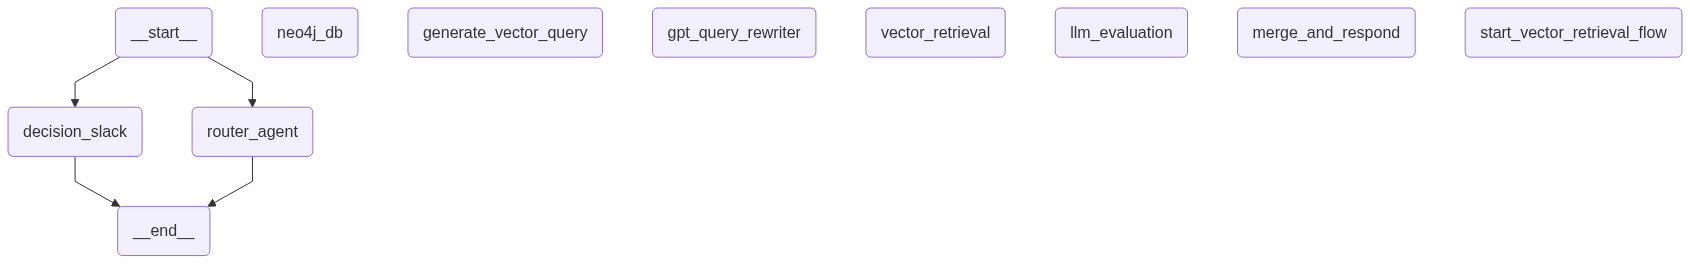

In [ ]:
# # ==============================================================================
# # 셀 9: 최종 Graph 빌드 및 컴파일
# # ==============================================================================
# workflow = StateGraph(ChatbotState)

# # 1. 노드 추가
# workflow.add_node("router_agent", router_agent)
# workflow.add_node("decision_slack", decision_slack)
# workflow.add_node("neo4j_db", neo4j_db)
# workflow.add_node("generate_vector_query", generate_vector_query_node)
# # --- VectorDB 검색/평가 루프 노드들 ---
# workflow.add_node("gpt_query_rewriter", gpt_query_rewriter_node)
# workflow.add_node("vector_retrieval", vector_retrieval_node)
# workflow.add_node("llm_evaluation", llm_evaluation_node)
# # --- 최종 노드 ---
# workflow.add_node("merge_and_respond", merge_and_respond_node)

# # 2. 엣지 연결
# workflow.add_edge(START, "router_agent")
# workflow.add_edge(START, "decision_slack")

# # 2-1. 라우터 이후 분기
# # vector_db가 필요한 모든 흐름을 gpt_query_rewriter로 보내기 위해 중간 라우팅 노드 추가
# # (START에서 여러 노드를 호출하는 것처럼, router_agent의 결과로 여러 노드를 호출하는 기능이 LangGraph에 직접적으로 없기 때문)
# def start_vector_flow(state: ChatbotState) -> ChatbotState:
#     print("\n--- Starting VectorDB Retrieval Flow ---")
#     # 병렬 흐름의 경우, neo4j_documents가 이미 채워져 있음
#     # 이 정보를 다음 노드들이 사용할 수 있도록 state를 그대로 전달
#     if state['flow_type'] == 'parallel':
#         return ChatbotState(
#             neo4j_documents=state['neo4j_documents'],
#             tools_query=state['tools_query'] # router에서 생성된 vector_db_query 사용
#         )
#     return state
# workflow.add_node("start_vector_retrieval_flow", start_vector_flow)

# workflow.add_conditional_edges("router_agent", route_after_router)
# workflow.add_conditional_edges("neo4j_db", route_after_neo4j)

# # 2-2. 순차 흐름: Neo4j -> VectorDB 쿼리 생성 -> VectorDB 검색 루프 시작
# workflow.add_edge("generate_vector_query", "gpt_query_rewriter")

# # 2-3. VectorDB 검색/평가 루프
# workflow.add_edge("start_vector_retrieval_flow", "gpt_query_rewriter")
# workflow.add_edge("gpt_query_rewriter", "vector_retrieval")
# workflow.add_edge("vector_retrieval", "llm_evaluation")
# workflow.add_conditional_edges("llm_evaluation", route_after_evaluation)

# # 2-4. 최종 응답 노드로 수렴
# workflow.add_edge("merge_and_respond", END)

# # 3. 그래프 컴파일
# graph = workflow.compile(checkpointer=memory)
# print("통합 그래프 컴파일 완료!")
# graph

.. ? ㅁㅊ ~

모든 노드가 올바르게 연결된 최종 그래프 컴파일 완료!


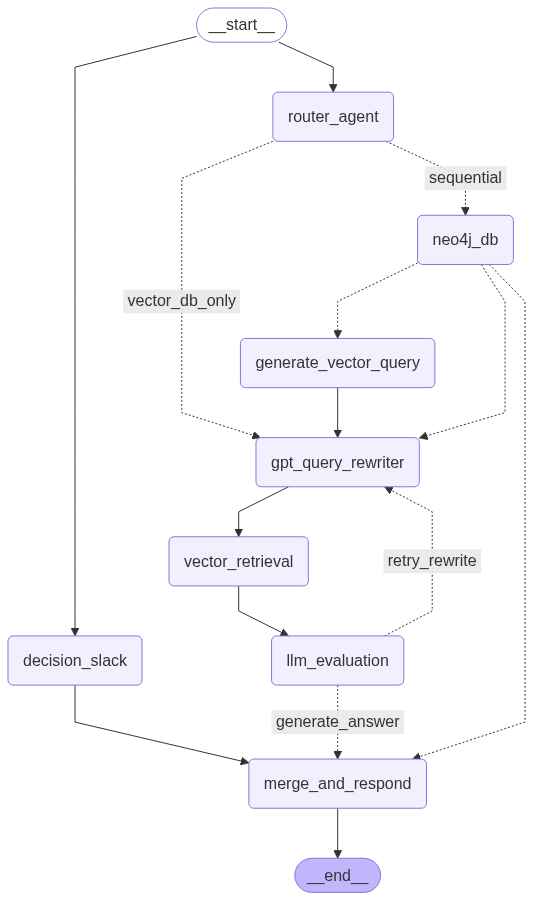

In [17]:
# ==============================================================================
# 셀 9: 최종 Graph 빌드 및 컴파일 (수정 완료)
# ==============================================================================
workflow = StateGraph(ChatbotState)

# 1. 모든 노드 정의
workflow.add_node("router_agent", router_agent)
workflow.add_node("decision_slack", decision_slack)
workflow.add_node("neo4j_db", neo4j_db)
workflow.add_node("generate_vector_query", generate_vector_query_node)
# --- VectorDB 검색/평가 루프 노드들 ---
workflow.add_node("gpt_query_rewriter", gpt_query_rewriter_node)
workflow.add_node("vector_retrieval", vector_retrieval_node)
workflow.add_node("llm_evaluation", llm_evaluation_node)
# --- 최종 노드 ---
workflow.add_node("merge_and_respond", merge_and_respond_node)

# 2. 시작점(START) 엣지 연결
# 라우터와 슬랙 결정은 병렬로 시작
workflow.add_edge(START, "router_agent")
workflow.add_edge(START, "decision_slack")

# 3. 라우터 이후의 조건부 분기 설정
workflow.add_conditional_edges(
    "router_agent",
    route_after_router,
    {
        "neo4j_only": "neo4j_db",
        "vector_db_only": "gpt_query_rewriter", # VectorDB가 필요하면 바로 쿼리 재작성 루프로 진입
        "parallel": "neo4j_db",                 # 병렬/순차는 먼저 Neo4j로
        "sequential": "neo4j_db",
    }
)

# 4. Neo4j 노드 이후의 조건부 분기 설정
workflow.add_conditional_edges(
    "neo4j_db",
    route_after_neo4j,
    {
        "merge_and_respond": "merge_and_respond", # neo4j_only 흐름은 바로 최종 응답으로
        "generate_vector_query": "generate_vector_query", # sequential 흐름은 쿼리 생성으로
        "gpt_query_rewriter": "gpt_query_rewriter"    # parallel 흐름은 바로 쿼리 재작성으로
    }
)

# 5. 순차(Sequential) 흐름의 나머지 엣지 연결
workflow.add_edge("generate_vector_query", "gpt_query_rewriter")

# 6. VectorDB 검색/평가 루프의 엣지 연결
workflow.add_edge("gpt_query_rewriter", "vector_retrieval")
workflow.add_edge("vector_retrieval", "llm_evaluation")

# 7. LLM 평가 이후의 조건부 분기 (재시도 루프)
workflow.add_conditional_edges(
    "llm_evaluation",
    route_after_evaluation,
    {
        "retry_rewrite": "gpt_query_rewriter",     # 점수 미달 시 재작성으로 복귀
        "generate_answer": "merge_and_respond", # 점수 통과 시 최종 응답으로
    }
)

# 8. 모든 흐름의 종착점 설정
# 슬랙 결정 노드의 결과를 최종 노드에서 사용하기 위해 연결
workflow.add_edge("decision_slack", "merge_and_respond")

# 9. 최종 노드와 종료점(END) 연결
workflow.add_edge("merge_and_respond", END)


# 10. 그래프 컴파일
graph = workflow.compile(checkpointer=memory)
print("모든 노드가 올바르게 연결된 최종 그래프 컴파일 완료!")
graph

In [18]:
# ==============================================================================
# 셀 10: 실행 함수 및 테스트
# ==============================================================================
async def run_chatbot(query, thread_id):
    config = {"configurable": {"thread_id": thread_id}}
    initial_state = {
        "question": query,
        "loop_cnt": 0,
        "messages": [HumanMessage(content=query)]
    }
    async for event in graph.astream(initial_state, config=config):
        for node_name, node_state in event.items():
            print(f"--- Event: Node '{node_name}' finished ---")
            if node_name == END:
                print("\n\n" + "="*50)
                print("최종 실행 결과:")
                print(f"  - 최종 답변: {node_state['final_answer']}")
                if node_state.get('slack_response'):
                    print(f"  - 슬랙 응답: {node_state['slack_response']}")
                print("="*50)

In [ ]:

# --- 테스트 실행 ---
async def main():
    # 테스트 1: VectorDB Only (자동 쿼리 보정)
    query1 = "3세 Kasabach-Merritt Syndrome 환자의 치료법에 대해서 조사해서 백지연에게 slack으로 보내줘."
    print("="*20 + " 테스트 1: VectorDB Only (With Self-Correction) " + "="*20)
    await run_chatbot(query1, "thread-1")
    
    print("\n\n" + "="*80 + "\n\n")

    # 테스트 2: Sequential (Neo4j -> VectorDB)
    # query2 = "6세 여아 폐렴 환자가 받을 수술을 알려주고, 수술에 사용될 마취 약물에 대해 조사해서 백지연에게 slack으로 보내줘."
    # print("="*20 + " 테스트 2: Sequential " + "="*20)
    # await run_chatbot(query2, "thread-2")

# Jupyter Notebook에서 실행
await main()

==================== 테스트 1: VectorDB Only (With Self-Correction) ====================

--- [Node] Decision Slack ---
Slack Decision: Yes

--- [Node] Router Agent ---
--- Event: Node 'decision_slack' finished ---
Flow Type: vector_db_only
--- Routing Decision: vector_db_only ---
--- Event: Node 'router_agent' finished ---

--- [Node] Query Rewriter (Attempt 1) ---

--- [Node] Merge and Respond ---
원본 번역: Please research the treatment methods for a 3-year-old patient with Kasabach-Merritt Syndrome and send it to Baek Ji-yeon via Slack.
GPT 재작성: treatment options for 3-year-old patient with Kasabach-Merritt Syndrome
Final Answer Generated: 3세 Kasabach-Merritt Syndrome 환자의 치료법에 대한 정보를 제공하기 위해서는 일반적으로 알려진 치료 옵션을 설명할 수 있습니다. Kasabach-Merritt...
--- Sending to Slack (Direct Call) ---
영어 번역: Please research the treatment options for a 3-year-old patient with Kasabach-Merritt Syndrome and send the information to Baek Ji-yeon via Slack.
의료 용어 확장: Please research the treatment options for a 3-yea